# Exercise 3
All previous instructions hold. In addition, if you are using GPU, you must check that your code also runs on a CPU. 

**Make sure you use the best practices you learned in class**.

In [21]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('device - {}'.format(device))

%matplotlib inline
plt.rcParams['figure.figsize'] = (12.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

print(torch.__version__)

device - cpu
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
1.1.0


# Convolutional Neural Network - Classifiying CIFAR-10 (30 points)

So far we had to manually implement both the forward and backward passes of our neural network. Manually implementing the backward pass is not a big deal for a small two-layer network, but can quickly get very messy for large complex networks.

Thankfully, we can use **automatic differentiation** to automate the computation of backward passes in neural networks. The autograd package in PyTorch provides exactly this functionality. When using autograd, the forward pass of your network will define a computational graph. Nodes in the graph will be Tensors,
and edges will be functions that produce output Tensors from input Tensors. Backpropagating through this graph then allows you to easily compute gradients.

If we want to compute gradients with respect to some Tensor, then we set `requires_grad=True` when constructing that Tensor. Any PyTorch operations on that Tensor will cause a computational graph to be constructed, allowing us to later perform backpropagation through the graph. If `x` is a Tensor with `requires_grad=True`, then after backpropagation `x.grad` will be another Tensor holding the gradient of `x`.

Sometimes you may wish to prevent PyTorch from building computational graphs when performing certain operations on Tensors with `requires_grad=True`; for example, we usually don't want to backpropagate through the weight update steps when evaluating a neural network. In such scenarios we can use the `torch.no_grad()` context manager to prevent the construction of a computational graph.

In this exercise, you will accomplish the following:
1. Train a convolutional network using PyTorch.
2. Evaluate your model using a confusion matrix.
3. Solve the localization task using regression.

### Data Preprocessing

In [22]:
# Hyper parameters
num_epochs = 5
batch_size = 64
learning_rate = 0.001

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

num_classes = len(classes)

Files already downloaded and verified
Files already downloaded and verified


Image shape:  torch.Size([3, 32, 32])
      frog       frog        dog      horse


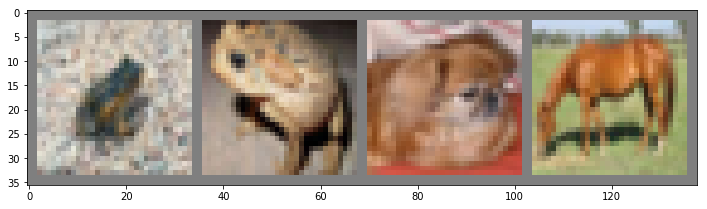

In [23]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # plt accepts images in the format (w,h,c)
    
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

print("Image shape: ", images[0].shape)
# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join('%10s' % classes[labels[j]] for j in range(4)))

### Construct a CNN in PyTorch - 20 points

In the following class, initiate your different layers in the `__init__` method and define your architecture in the `forward` method. Make sure the `forward` method has a single return value. 

1. Make good use of the documentation and experiment will different layers, activations and architectures, batch sizes, regularization, filter sizes, dimensions, number of layers and whatever you learned in class. 
2. Use your intuition from the previous exercises and additional sources such as the Piazza, papers, etc. - do not try to perform a massive grid search.
3. **Include only your chosen architecture**. During experimentation, you may add as many cells as you need. Make sure to delete them before submission.
4. Make sure your code runs reasonably fast (~30 minutes on CPU and ~5 minutes on GPU).
5. Use the best architecture you find and train it for 5-10 epochs. 
6. Explain why you chose that architecture and why you think it performs better than other networks you tried. Cite papers, blogs, MOOCs, online guides and every other source you used during optimization.
7. Visualize the loss and accuracy of your network during training. You can use matplotlib or tensorboard.
8. **You should get close to 75% accuracy, explain you results and include visualizations for the full 20 points**.

In [24]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #############################################################################
        # TO DO:                                                                    #
        # Initiate the different layers you wish to use in your network.            #
        # This method has no return value.                                          #
        #############################################################################
        
        self.layer1 = nn.Sequential(
              nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
              nn.BatchNorm2d(32),
              nn.ReLU(inplace=True),
              nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer2 = nn.Sequential(
              nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
              nn.BatchNorm2d(64),
              nn.ReLU(inplace=True),
              nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer3 = nn.Sequential(
              nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
              nn.BatchNorm2d(128),
              nn.ReLU(inplace=True),
              nn.MaxPool2d(kernel_size=2, stride=2)
        )      
        self.layer4 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.fc_layer = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.Linear(1024, num_classes)
        )
        
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################
        
    def forward(self, x):
        #############################################################################
        # TO DO:                                                                    #
        # Define the forward propagation. You need to pass an image through the     #
        # network and obtain class predictions.                                     #
        # This function returns the predication of your model.                      #
        #############################################################################
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        # Adding dropout by the end of the conv nets
        x = nn.Dropout2d(p=0.05)(x)

        x = x.view(x.size(0), -1)
        
        x = self.fc_layer(x)

        return x
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

net = Net().to(device)
criterion = None
optimizer = None
#############################################################################
# TO DO:                                                                    #
# Define the loss function and optimizer.                                   # 
#############################################################################
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SDG(net.parameters(), lr=learning_rate, momentum=0.9)
optimizer = optim.Adam(net.parameters(), lr=learning_rate)
#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

In [25]:
#############################################################################
# TO DO:                                                                    #
# Define the training loop as seen in class and as demonstrated in the      #
# documentation. Note, if you are using GPU, make sure your code runs on    #
# CPU also. Code that cannot run will not be tested.                        # 
#############################################################################
import time
start = time.time()
print(
    "start train time - {}".format(str(time.ctime(int(start))))
)

loss_history = []
train_acc_history = []

for epoch in range(num_epochs):
    
    net.train()
    
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        def to_device(inputs, labels):
            return inputs.to(device), labels.to(device)
        
        inputs, labels = to_device(*data)

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        loss_history.append(loss.item())
        optimizer.step()
        optimizer.zero_grad()
        
        _, argmax = torch.max(outputs, 1)
        accuracy = (labels == argmax.squeeze()).float().mean()
        train_acc_history.append(accuracy.item())

        if i % 500 == 0:
            print('[%d, %5d] loss: %.3f, acc: %.3f' %
                  (epoch, i , loss.item(), accuracy.item()))
        

end = time.time()
print('Finished Training in - {} min'.format((end - start)/60))
#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

start train time - Mon May 20 01:18:18 2019
[0,     0] loss: 2.310, acc: 0.109
[0,   500] loss: 0.986, acc: 0.688
[1,     0] loss: 0.697, acc: 0.750
[1,   500] loss: 0.827, acc: 0.719
[2,     0] loss: 0.621, acc: 0.781
[2,   500] loss: 0.465, acc: 0.875
[3,     0] loss: 0.543, acc: 0.797
[3,   500] loss: 0.559, acc: 0.828
[4,     0] loss: 0.332, acc: 0.875
[4,   500] loss: 0.387, acc: 0.859
Finished Training in - 12.357061068216959 min


GroundTruth:      cat    ship    ship   plane
Predicted:        cat    ship    ship   plane


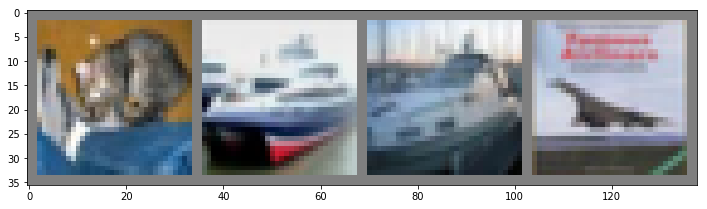

In [26]:
dataiter = iter(testloader)
images, labels = dataiter.next()
images, labels = images.to(device), labels.to(device)
imshow(torchvision.utils.make_grid(images[:4]))
print('GroundTruth: ', ' '.join('%7s' % classes[labels[j]] for j in range(4)))
outputs = net(images)
_, predicted = torch.max(outputs, 1)
print('Predicted:   ', ' '.join('%7s' % classes[predicted[j]]for j in range(4)))

## Model evaluation - 10 points

Calculate the model accuracy and print a confusion matrix where in y axis represents the real category and the x axis represents the predicted category. You are allowed to use loops. **Explain the results**: what can you learn from the confusion matrix? Why do you need additional evaluation methods other than accuracy?

### Explanation and References:
We based our solution on PyTourch examples from class and got helped from the following tutorials:

https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
https://github.com/yunjey/pytorch-tutorial/blob/master/tutorials/02-intermediate/convolutional_neural_network/main.py

The tutorials put us on about 60% accuracy, we tried by trail and error different tactics and combinations as learned in class. What mainly helped was increasin the number of layers.

1) We used different optimizers, althgouh we understand pretty fast that Adam is one of the most widely used and the one we choose (SGD, Adam and more).

2) We tried different loss function (CrossEntropyLoss, MSELoss, L1Loss) and chose CrossEntropyLoss

3) We played with the different Hyper parameters (learning rate, batch size, num of epoch (5-10)

4) We tried different number of layers and different non-linear activation functions (ReLU, RReLU, SELU) between them - RelU was chosen.

5) We used BatchNorm before the activation to normelize the input

6) We used MaxPool layer for down-sampling

7) Adding a 5th layer inproved our model in around 2% (we reached ~90% on the training data), and increased the training time, so we decide to stick to 4 layers. asa well as increasng the amount of epochs 

### Results explanation:
As we can see in the confusion matrix, the diagonal values are the heighset which indicates a pretty good prediction level. 
We can also learn about misclassification and wrong predictions of the model, which is hard to distinguish by accuracy alone. As well we can see which class did we classified the best!

In [27]:
confusion_matrix = np.zeros([num_classes,num_classes], int)
model_accuracy = 0
#############################################################################
# TO DO:                                                                    #
# Define the evaluation loop as seen in class and as demonstrated in the    #
# documentation and use the confusion matrix to evaluate your model.        # 
#############################################################################
correct = 0
total = 0
with torch.no_grad():
    
    net.eval()
    
    for data in testloader:
        images, labels = to_device(*data)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        for label_index, label in enumerate(labels):
            confusion_matrix[label.item(), predicted[label_index].item()] += 1 

model_accuracy = 100 * correct / total

#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################
print('Model accuracy on {0} test images: {1:.2f}%'.format(len(testset), model_accuracy))

Model accuracy on 10000 test images: 78.96%


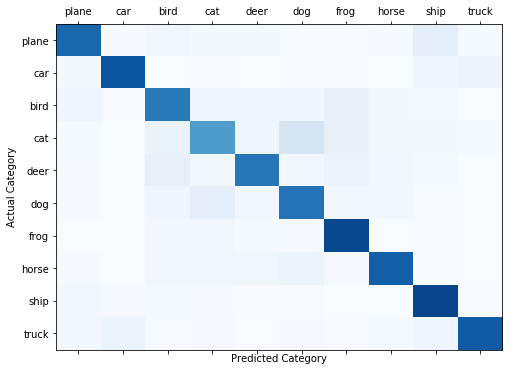

Category   - Accuracy
plane      - 78.7
car        - 86.1
bird       - 71.6
cat        - 58.5
deer       - 73.3
dog        - 74.1
frog       - 90.6
horse      - 81.7
ship       - 92.0
truck      - 83.0


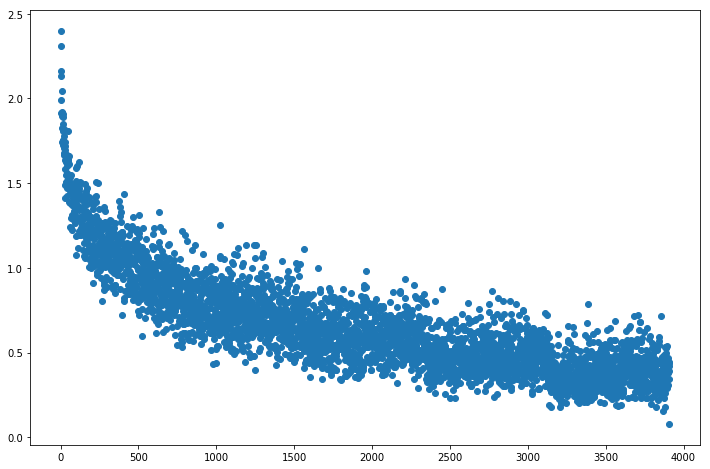

In [28]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.matshow(confusion_matrix, aspect='auto', vmin=0, vmax=1000, cmap=plt.get_cmap('Blues'))
plt.ylabel('Actual Category')
plt.yticks(range(10), classes)
plt.xlabel('Predicted Category')
plt.xticks(range(10), classes)
plt.show()

# loss scattering
plt.scatter(range(len(loss_history)), loss_history)

# Confusion matrix acctual values per calss, while 
print('{0:10s} - {1}'.format('Category','Accuracy'))
for i, r in enumerate(confusion_matrix):
    print('{0:10s} - {1:.1f}'.format(classes[i], r[i]/np.sum(r)*100))

# Localization as Regression (60 points)

State of the art accuracy on CIFAR10 is currently ~99% on the test set. In the next part, we will use a well known architecture called ResNet18 that was trained on ImageNet, a dataset far more rich than CIFAR10. ImageNet has 1,000 classes and 1,000,000 images and the pretrained ResNet18 available in PyTorch correctly classifies ~70% of the test set. In this part, we will use the features extracted from ResNet18 to localize and classify images of cats and dogs. 

Using a pretrained network as a building block for a more complicated task is at the heart of neural networks today. By leveraging the features ResNet18 extracts, we can train a model that can correctly classify and localize cats and dogs using very few images. 

In [ ]:
import torchvision.transforms as transforms
from data.dataloader import *
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torchvision.models as models
import torch.nn as nn
from PIL import Image
import collections
import time
import copy
import sys
import os

To load ResNet18 with the pretrained weights, use the following line. You are welcome to try different architectures, however they might require different input sizes or normalization.

The first time you run this cell the weights will be downloaded.

In [ ]:
resnet18 = models.resnet18(pretrained=True)

ResNet takes as input images of size (224,224). We will use PyTorch Transforms to change the size of the images. When ResNet18 was trained on ImageNet, the images were normalized using the mean and standard deviation of the images. In order to properly use the weights, we will use the same normalization.

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        Rescale((224,224)),
        ToTensor(),
        Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalizing according to imagenet
    ]),
    'val': transforms.Compose([
        Rescale((224,224)),
        ToTensor(),
        Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
root_dir = "data/animals/"
datasets = {x: VOCDetection(root_dir, image_set=x, transform=data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(datasets[x], batch_size=32, shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(datasets[x]) for x in ['train', 'val']}
classes = datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(dataset_sizes)

In [ ]:
# Get a batch of training data
sample = next(iter(dataloaders['train']))

In [ ]:
def imshow(img, label, bbox):
    image = np.copy(img[0])
    image = np.transpose(image, (1, 2, 0))
    image *= np.array([0.229, 0.224, 0.225])
    image += np.array([0.485, 0.456, 0.406])
    label = label[0]
    bbox = bbox[0]
    plt.figure();
    fig, ax = plt.subplots(1, figsize=(12,9));
    ax.imshow(image);
    x1, y1, x2, y2 = bbox.numpy().reshape(-1) * 224
    box_w, box_h = np.abs(x2-x1), np.abs(y2-y1)
    bbox = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2, 
                             edgecolor='r', facecolor='none');
    ax.add_patch(bbox);
    ax.annotate(classes[label], (x1, y1), color='r', fontsize=14);

imshow(sample['image'],sample['label'],sample['bbox'])

In [ ]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        #############################################################################
        # TO DO:                                                                    #
        # Load the pretrained ResNet-18 network and replace the top fully connected #
        # layer, so we could pass the features of the network and not the only      #
        # the classification layer which carries significantly less information.    #
        # Afterwards, create a new sequential model with the remaining layers of    #
        # the pretrained network. Next, define two additional models that take as   #
        # input the extracted features and output the class scores and bounding box #
        # coordinates.                                                              #
        # This function has no return value.                                        #
        #############################################################################
        pass
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################
    
    def forward(self, images):
        #############################################################################
        # TO DO:                                                                    #
        # Define the forward propagation. You need to pass an image through the     #
        # network and extract the feature vector. In this case, when using a        #
        # predefined network, you don't want to change it's weights.                #
        # The rest of the layers you defined should accepts gradients for them to   #
        # improve during training.                                                  #
        # This function returns a class predication and a bounding box coordinates. #
        #############################################################################
        pass
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

## Guidelines

1. Complete the `train_model` function in the cell below. This function takes as input the model and additional hyper-parameters, and outputs the best model found on the validation set. 
2. To babysit the learning process, **you must track the classification accuracy, IoU score and loss on the training and validation datasets and visualize them** (using tensorboard or matplotlib). I have included an implementation of the IoU metric in the file `data\dataloader.py`.
3. Do not perform a massive grid search. Use papers, blogs, MOOCs and online guides to research best hyper-parameters for your model. Once you chose your model. Explain why you chose that architecture and why you think it performs better than other networks you tried - use citation from sources you used.
4. You are encouraged to try Google Colab or a free AWS / Google Cloud Platform / Azure available for students. If you have an CUDA capable GPU at home - you are welcome to use it. Training one of our networks on a Core i7 for 10 epochs took 5 minutes and reached 99% classification accuracy and over 0.75 IoU score on the validation set (this took less than a minute using a RTX 2080 Ti GPU).
5. **Include only your chosen architecture**. During experimentation, you may add as many cells as you need. Make sure to delete them before submission.
6. Training large neural networks may take a while. Make sure your code runs reasonably fast (~30 minutes on CPU and ~5 minutes on GPU).
7. **In order to get full marks for this section, reach at least 98% classification accuracy and a IOU score of at least 0.70 on the validation set using a single model, explain the results and include visualizations**.
8. You are given a general skeleton for the training function. Feel free to use any different structure.

In [ ]:
def train_model(model, criterion_cls, criterion_bbox, optimizer, scheduler=None, num_epochs=5):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict()) # this is how a model is copied
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0   # total loss of the network at each epoch
            running_corrects = 0 # number of correct predictions
            iou = 0.0            # IoU score
            
            # Iterate over data.
            for sample in dataloaders[phase]:
                #############################################################################
                # TO DO:                                                                    #
                # Extract the data from the dataloader, calculate the predictions of your   #
                # network and calculate the loss of the classification and bounding box     #
                # prediction. When in training mode, back-prop and update the weights.      #
                # At each epoch, calculate the test and train accuracy and IoU.             #
                # This function returns the best model in terms of accuracy.                #
                #############################################################################
                pass
                #############################################################################
                #                             END OF YOUR CODE                              #
                #############################################################################

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            iou = iou.item() / dataset_sizes[phase]
            
            print('{} Loss: {:.4f}  |  Acc: {:.4f}  |  IOU: {:.4f}'.format(
                phase, epoch_loss, epoch_acc, iou))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Choose your optimizer and the loss functions for the classification and bounding box regression.

In [ ]:
import torch.optim as optim

cnn = CNN(2)
cnn = cnn.to(device)

criterion_cls = None
criterion_bbox = None
optimizer = None
#############################################################################
#                           START OF YOUR CODE                              #
#############################################################################
pass
#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

In [ ]:
best_model = train_model(cnn, criterion_cls, criterion_bbox, optimizer, num_epochs=10)

Once you are pleased with your results, see how your model can predict and localize cats and dogs!

In [ ]:
# Get a batch of validation data
sample = next(iter(dataloaders['val']))
with torch.no_grad():
    images = sample['image']
    images = images.to(device)
    label_pred, bbox_pred = best_model(images)
    _, label_pred = torch.max(label_pred, 1)
imshow(sample['image'], label_pred.cpu(), bbox_pred.cpu())

Your visualizations here (IoU / Accuracy / Loss on training and validation datasets as a function of the epoch). Only visualize the results of your best model. If you want to paste an image in the notebook (such as png), make sure you include it in your submission. If you used Tensorboard, make sure you include the tfevent files.